### Install dependencies and load common Variables
<font color='Red' size="3"><i>IMPORTANT: </i></font><font color='Black' size="3"><i>(( Always excecute this two cells at the beggining))</i></font>

**Dependencies:**

<font color='Red' size="3">Tested in Kaggle and Google Colab</i></font>

---------

ipython==5.5.0

pandas==1.3.3

numpy==1.19.5

seaborn==0.11.2

matplotlib==3.2.2

datasets==1.14.0

tensorflow==2.6.0

scikit-learn==0.22.2

transformers==4.5.1 or 4.12.2

sentence-transformers==2.1.0

---------


In [6]:
# IMORT LIBRARIES

import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.layers import GlobalMaxPool1D, concatenate
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

from datasets import load_dataset

from transformers import AutoTokenizer, TFAutoModel
from sentence_transformers import SentenceTransformer


In [7]:
###      WRITE HERE THE MAIN FOLDER      ###

BASE_FOLDER = './'

###  ---------------------------------------------------------------------------------  ###



###  OTHER DIRECTORIES, PATHS AND NAMES  ###

TEST_DATA_DIR = BASE_FOLDER+'test-data/'
TRAIN_DATA_DIR = BASE_FOLDER+'train-val-data/'
CHECKPOINT_PATH = BASE_FOLDER + "model-checkpoint/TransferLearning_HEALTH_FACT_weights.ckpt"

# make the directory
try: os.mkdir(TRAIN_DATA_DIR)
except FileExistsError: pass

try: os.mkdir(TEST_DATA_DIR)
except FileExistsError: pass

try: os.mkdir('model-checkpoint') 
except FileExistsError: pass
  
# model names
MODEL1_NAME = 'deepset/sentence_bert'
MODEL2_NAME = "bert-base-cased"
# MODEL2_NAME = "giacomomiolo/scibert_reupload"

###  ---------------------------------------------------------------------------------  ###


### Load dataset and start Preprocessing

In [23]:
# LOAD DATASET 'HEALTH_FACT'
# if thrown --> ConnectionError: Couldn't reach https://drive.google.com/uc?export=download&id=1eTtRs5cUlBP5dXsx-FTAlmXuB6JQi2qj
# just try again.

dataset = load_dataset('health_fact')
dataset


Using custom data configuration default


Downloading:   0%|          | 0.00/24.9M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 9832
    })
    test: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 1235
    })
    validation: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 1225
    })
})

In [24]:

pprint(dataset['train'][1])


{'claim': 'Annual Mammograms May Have More False-Positives',
 'claim_id': '9893',
 'date_published': 'October 18, 2011',
 'explanation': 'This article reports on the results of a study of nearly '
                '170,000 women who had screening mammograms beginning between '
                'age 40-59. The study found that over ten years of screening '
                'mammograms, over half of the women will experience a '
                'false-positive recall for additional mammography. In '
                'addition, 7%-9% of the women will have a biopsy for a '
                'suspicious lump which is not cancerous. Both of those '
                'percentages decrease if the woman is screened every other '
                'year rather than every year. Even with biennial mammography, '
                '41% of women will experience a\xa0recall over 10 years of '
                'mammography. The study’s Principal Investigator emphasized '
                'that “in most cases, a re

In [25]:
# Convert TRAIN, TEST and VAL datasets into Pandas Dataframe, and only stay with columns claims, main_text and labels

df_train = pd.DataFrame(dataset['train'], columns=['claim', 'main_text', 'label'])
df_test = pd.DataFrame(dataset['test'], columns=['claim', 'main_text', 'label'])
df_val = pd.DataFrame(dataset['validation'], columns=['claim', 'main_text', 'label'])

# Concatenate train, test and val
df = pd.concat([df_train, df_test, df_val])

# delete dataset y dfs
del dataset, df_train, df_test, df_val

df.head()


,claim,main_text,label
0,"""The money the Clinton Foundation took from fr...","""Hillary Clinton is in the political crosshair...",0
1,Annual Mammograms May Have More False-Positives,While the financial costs of screening mammogr...,1
2,SBRT Offers Prostate Cancer Patients High Canc...,The news release quotes lead researcher Robert...,1
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...","The story does discuss costs, but the framing ...",2
4,Some appendicitis cases may not require ’emerg...,"""Although the story didn’t cite the cost of ap...",2


In [26]:

len(df)


12292

In [27]:
# this website https://huggingface.co/datasets/viewer/?dataset=health_fact 
# says --> NOTE: There are missing labels in the dataset and we have replaced them with -1.

# explore missing labels
mask = df['label'] == -1

print('Missing labels:', len(df[mask]), sep='\t')


Missing labels:	41


In [28]:
# DROP MISSING DATA

print('Previous size: '+str(len(df)))

# drop rows with missing values
df.drop(df[mask].index, inplace=True)

print('Current size: '+str(len(df)))

# Reset index
df.reset_index(inplace=True, drop=True)  


Previous size: 12292
Current size: 12225


In [29]:
# SPLIT MAIN TEXT

# Split main_text each Semicolon, Comma and Period
def split_text(text):
    text = text.replace(".", ",")
    text = text.replace(";", ",")
    return text.split(",")

df['main_text'] = df['main_text'].apply(split_text)
print(df['main_text'][0][:2])


['"Hillary Clinton is in the political crosshairs as the author of a new book alleges improper financial ties between her public and personal life', ' At issue in conservative author Peter Schweizer’s forthcoming book Clinton Cash are donations from foreign governments to the Clinton Foundation during the four years she served as secretary of state']


### First transformer "sentence_bert"

If we want to Download or Clone the transforer 'Sentence_bert'

```
git lfs install
git clone https://huggingface.co/deepset/sentence_bert
```

but if we are going to download it on the go, then just continue

In [30]:
# LOAD MODEL SENTENCE_BERT

model = SentenceTransformer(MODEL1_NAME)


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/188 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/deepset_sentence_bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# CHECK GPU

tf.config.experimental.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
# FUNCTIONS TO GET THE TOP K SIMILAR SENTENCES


def list_to_string(list_main_text):
  main_text = ""
  
  for seq in list_main_text:
      if seq == "": continue
      
      if seq[0] != " ": 
          main_text += " " + seq
      else: 
          main_text += seq

  return main_text
  


def get_top_k_similar_sentences(claim, list_main_text, k):
  # Insert claim in main_text to encode together
  list_main_text.insert(0, claim)

  # encode
  sentences_embeddings = model.encode(list_main_text)

  # Delete claim from main_text
  list_main_text.remove(claim)


  # Calculate cosine similarity
  cos_sim = cosine_similarity([sentences_embeddings[0]], sentences_embeddings[1:])


  # get the indices of the top k sentences 
  indices = sorted(range(len(cos_sim[0])), key=lambda i: cos_sim[0][i])[-k:] 

  # call the function
  list_main_text = list_to_string(np.array(list_main_text)[indices])

  return list_main_text
  

In [32]:
# FUNCTION TO CLEAR OUTPUT

from IPython.display import clear_output # this is for notebooks

def clear(index=0, each=1):
    #Clear each 50 iterations
    if index%each == 0:
        # this only works in notebooks
        clear_output(wait=False)
        # for windows
        if os.name == 'nt':
            _ = os.system('cls')
        # for mac and linux(here, os.name is 'posix')
        else:
            _ = os.system('clear')
            

In [ ]:
# GET THE TOP K SIMILAR SENTENCES OF THE COLUMN 'main_text'
### -------------------------------------------------- ###
""" THIS IS A TRAINING PROCESS SO THIS LASTS SOME TIME
    To skip this step, we can jump into the next one, 
    and load the data from the disk.                   """
### -------------------------------------------------- ###


# disable the warning 'SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame'
pd.options.mode.chained_assignment = None  # default='warn'

k=7
# get the top 7 similar sentences 
for i in range(len(df['claim'])):
    try:
        df['main_text'][i] = get_top_k_similar_sentences(df['claim'][i], df['main_text'][i], k)
        clear(i, each=50)
    except: pass
clear()

# PRINT THE LAST DATA
last_index = len(df['main_text'])-1 
print('Clain:', df['claim'][last_index])
print('\n')
print('Main Text:', df['main_text'][last_index]) # Top k Sentences Joined


# SAVE DATAFRAME WITH TOP 7 SENTENSES
df.to_pickle(BASE_FOLDER+"df_data.pkl")
# delete dataset from the memory
del df


Clain: US regulators clear path for genetically modified salmon.


Main Text:  He also noted the disclosure regulation uses the term “bioengineered and that it lifted its alert because the fish would be subject to a new regulation that will require companies to disclose when a food is bioengineered Massachusetts-based company from importing its fish eggs until disclosure guidelines for genetically modified foods were resolved Salmon eggs could then be sent from the company’s research and development facility in Canada the fish is Atlantic salmon modified with DNA from other fish species to grow faster The genetically modified salmon are raised in tanks and bred to be female and sterile its salmon became the first genetically modified animal approved by the FDA for human consumption


----------------

----------------

In [4]:
### LOAD DATASET WITH THE TOP 7 SENTENSES ###
""" (NOTE: we can skip all previous steps 
     by loading this file from the disk)  """"


df = pd.read_pickle(BASE_FOLDER + 'df_data.pkl')
df.head()


,claim,main_text,label
0,"""The money the Clinton Foundation took from fr...",But the gifts in this case were donations fro...,0
1,Annual Mammograms May Have More False-Positives,Screening mammography is widely available thr...,1
2,SBRT Offers Prostate Cancer Patients High Canc...,which are likely to be equally good with almo...,1
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...",We read more sooner about the one patient who...,2
4,Some appendicitis cases may not require ’emerg...,we can’t be sure of the extent to which it ma...,2


### plot the distribution to choose a sequence length for main_text and claims

In [5]:
sns.set_style('darkgrid')

# Plot distPlot
def distplot(seq_len):
  plt.figure(figsize=(16, 10))
  sns.distplot(seq_len)
  plt.show()
  

In [6]:

# Get the length of each claim and main_text
claim_seqs_len = df['claim'].apply(lambda x: len(x.split()))
main_text_seqs_len = df['main_text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


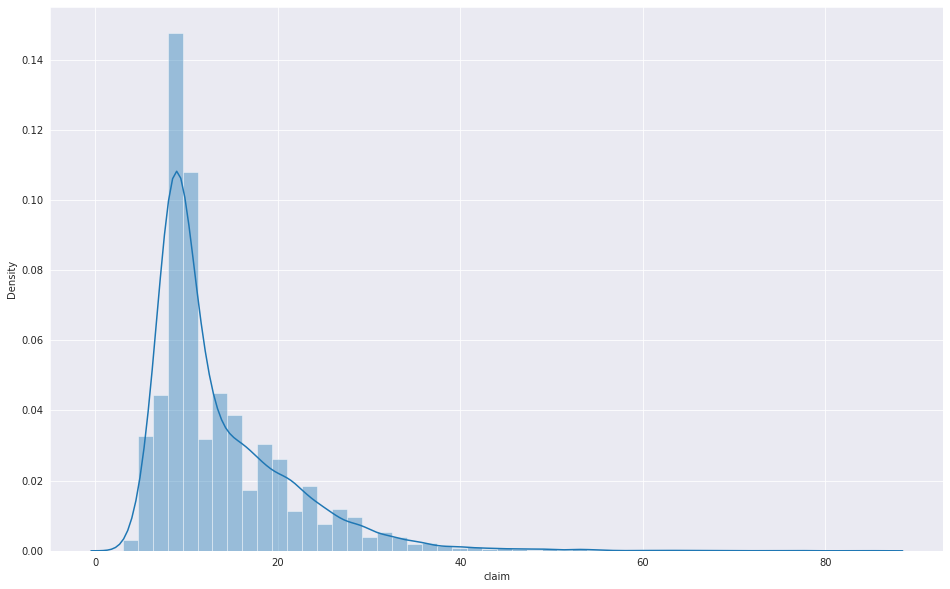

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


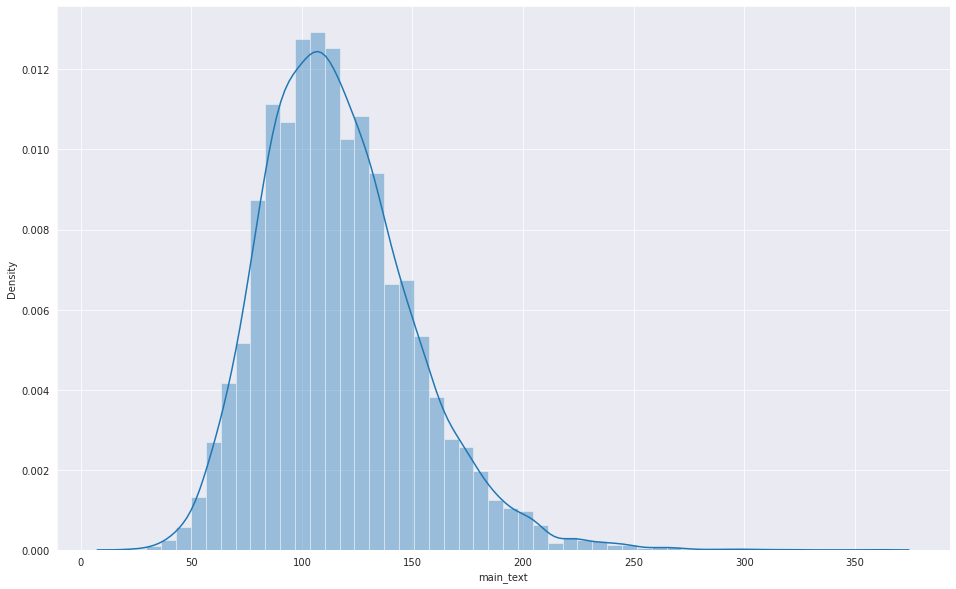

In [7]:

# distPlot for claims and main_texts
distplot(claim_seqs_len)
distplot(main_text_seqs_len)


In [8]:

# cut claims off in 45 because the plot shows that there is almost nothing higher than 45
CLAIM_SEQ_LEN = 45

# cut main_text off in 270 for the same reason
M_TEXT_SEQ_LEN = 270


## main transformer "bert-base-cased"

If we want to Download or Clone the transforer 'bert-base-cased'

```
git lfs install
git clone https://huggingface.co/bert-base-cased
```

but if we are going to download it on the go, then just continue

In [ ]:

# get the tokens
tokenizer = AutoTokenizer.from_pretrained(MODEL2_NAME)


In [ ]:

# Create the arrays to store input_ids and attention_mask for claims and main_texts
Xids_Claims = np.zeros((len(df), CLAIM_SEQ_LEN))
Xmask_Claims = np.zeros((len(df), CLAIM_SEQ_LEN))

Xids_Mtext = np.zeros((len(df), M_TEXT_SEQ_LEN))
Xmask_Mtext = np.zeros((len(df), M_TEXT_SEQ_LEN))


In [ ]:

print(Xids_Claims.shape)
print(Xids_Mtext.shape)


(12225, 45)
(12225, 270)


In [ ]:

# Get inputs_ids and attention_masks
for i, sequences in enumerate(zip(df['claim'], df['main_text'])):
    claim, main_text = sequences[0], sequences[1]                            

    tokens = tokenizer.encode_plus(claim, max_length=CLAIM_SEQ_LEN,
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors='tf')
    Xids_Claims[i, :], Xmask_Claims[i, :] = tokens['input_ids'], tokens['attention_mask']

    tokens = tokenizer.encode_plus(main_text, max_length=M_TEXT_SEQ_LEN,
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors='tf')
    Xids_Mtext[i, :], Xmask_Mtext[i, :] = tokens['input_ids'], tokens['attention_mask']
    

In [ ]:
# PRINT CLAIMS (IDS AND MASK)

print(Xids_Claims)
print()
print(Xids_Claims.shape)

print('\n\n')

print(Xmask_Claims)
print()
print(Xmask_Claims.shape)


[[  101.   107.  1109. ...     0.     0.     0.]
 [  101.  8451.  7085. ...     0.     0.     0.]
 [  101.   156. 26166. ...     0.     0.     0.]
 ...
 [  101.  9018.  1116. ...     0.     0.     0.]
 [  101.   156. 12415. ...     0.     0.     0.]
 [  101.  1646. 27335. ...     0.     0.     0.]]

(12225, 45)



[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]

(12225, 45)


In [ ]:
# PRINT MAIN TEXTS (IDS AND MASK)

print(Xids_Mtext)
print()
print(Xids_Mtext.shape)

print('\n\n')

print(Xmask_Mtext)
print()
print(Xmask_Mtext.shape)


[[  101.  1252.  1103. ...     0.     0.     0.]
 [  101. 15652.  1158. ...     0.     0.     0.]
 [  101.  1134.  1132. ...     0.     0.     0.]
 ...
 [  101.   192.  3031. ...     0.     0.     0.]
 [  101.  1188.  1836. ...     0.     0.     0.]
 [  101.  1124.  1145. ...     0.     0.     0.]]

(12225, 270)



[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]

(12225, 270)


#### Create One hot encoded Labels

In [ ]:

# get the labels from the dataset
arr_labels = df['label'].values

# create a numpy array of zeros with shape (array size, ammount of labels)
labels = np.zeros((arr_labels.size, arr_labels.max()+1)) 
labels.shape


(12225, 4)

In [ ]:

print(np.arange(arr_labels.size))
print(arr_labels)
print(arr_labels.size)


[    0     1     2 ... 12222 12223 12224]
[0 1 1 ... 2 1 2]
12225


In [ ]:

# Create a range of values from 0 to 12224 and within that we add 1 to the 12225 labels 
# in the position of its number (0,1,2,3)
labels[np.arange(arr_labels.size), arr_labels] = 1
labels


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [ ]:
# EXTRACT 10% OF THE DATA FOR TEST

test_size = int(len(Xids_Claims) * 0.1) # 10%

Xids_Claims_test = Xids_Claims[0:test_size]
Xmask_Claims_test = Xmask_Claims[0:test_size]
Xids_Mtext_test = Xids_Mtext[0:test_size]
Xmask_Mtext_test = Xmask_Mtext[0:test_size]
labels_test = labels[0:test_size]

Xids_Claims = Xids_Claims[test_size:]
Xmask_Claims = Xmask_Claims[test_size:]
Xids_Mtext = Xids_Mtext[test_size:]
Xmask_Mtext = Xmask_Mtext[test_size:]
labels = labels[test_size:]


print(Xids_Claims.shape)
print(Xids_Claims_test.shape)


(11003, 45)
(1222, 45)


#### Save all the data and Reload it

In [ ]:
# SAVE ALL THE DATA

# train and val 
with open(TRAIN_DATA_DIR+'Xids_Claims.npy', 'wb') as f:
  np.save(f, Xids_Claims)
with open(TRAIN_DATA_DIR+'Xmask_Claims.npy', 'wb') as f:
  np.save(f, Xmask_Claims)
with open(TRAIN_DATA_DIR+'Xids_Mtext.npy', 'wb') as f:
  np.save(f, Xids_Mtext)
with open(TRAIN_DATA_DIR+'Xmask_Mtext.npy', 'wb') as f:
  np.save(f, Xmask_Mtext)
with open(TRAIN_DATA_DIR+'labels.npy', 'wb') as f:
  np.save(f, labels)

# test 
with open(TEST_DATA_DIR+'Xids_Claims_test.npy', 'wb') as f:
  np.save(f, Xids_Claims_test)
with open(TEST_DATA_DIR+'Xmask_Claims_test.npy', 'wb') as f:
  np.save(f, Xmask_Claims_test)
with open(TEST_DATA_DIR+'Xids_Mtext_test.npy', 'wb') as f:
  np.save(f, Xids_Mtext_test)
with open(TEST_DATA_DIR+'Xmask_Mtext_test.npy', 'wb') as f:
  np.save(f, Xmask_Mtext_test)
with open(TEST_DATA_DIR+'labels_test.npy', 'wb') as f:
  np.save(f, labels_test)


# delete every data from the memory
del df, Xids_Claims, Xmask_Claims, Xids_Mtext, Xmask_Mtext, labels
del Xids_Claims_test, Xmask_Claims_test, Xids_Mtext_test, Xmask_Mtext_test, labels_test


---------------

In [13]:
# LOAD TRAIN AND VAL DATA (we can just upload this data, and skip the previous data preprocessing steps)

with open(TRAIN_DATA_DIR+'Xids_Claims.npy', 'rb') as f:
  Xids_Claims = np.load(f)
with open(TRAIN_DATA_DIR+'Xmask_Claims.npy', 'rb') as f:
  Xmask_Claims = np.load(f)
with open(TRAIN_DATA_DIR+'Xids_Mtext.npy', 'rb') as f:
  Xids_Mtext = np.load(f)
with open(TRAIN_DATA_DIR+'Xmask_Mtext.npy', 'rb') as f:
  Xmask_Mtext = np.load(f)
with open(TRAIN_DATA_DIR+'labels.npy', 'rb') as f:
  labels = np.load(f)
  

In [14]:

print(Xids_Claims)
print(Xids_Claims.shape)


[[  101. 16752. 19951. ...     0.     0.     0.]
 [  101. 13597.  1455. ...     0.     0.     0.]
 [  101.  1284.  1132. ...     0.     0.     0.]
 ...
 [  101.  9018.  1116. ...     0.     0.     0.]
 [  101.   156. 12415. ...     0.     0.     0.]
 [  101.  1646. 27335. ...     0.     0.     0.]]
(11003, 45)


#### Put our array into a tensorflow dataset object

In [15]:
# CREATE THE TENSORFLOW DATASET OBJECT

dataset = tf.data.Dataset.from_tensor_slices((Xids_Claims, Xmask_Claims, 
                                              Xids_Mtext, Xmask_Mtext, labels))

for i in dataset.take(1): print(i)


(<tf.Tensor: shape=(45,), dtype=float64, numpy=
array([  101., 16752., 19951.,  1167., 13552.,  2949.,  1336.,  3244.,
        1222., 15007.,   102.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.])>, <tf.Tensor: shape=(45,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(270,), dtype=float64, numpy=
array([  101.,  1109.,  1642., 20417.,   170.,  3746.,   110.,  2211.,
        6625.,  3187.,  1111., 12885.,  4713.,  1104., 13552.,  2949.,
        1109.,  2616.,  1104., 13552.,  2949.,  1110.,  1136.,  1107.,
        2304.,  1109., 11731.,  110

In [16]:

# map the info with the data in a dic and the labels outside of the dic in the tuple
def map_func(input_ids_claims, masks_claims,input_ids_mtext, masks_mtext, labels):
  return {'input_ids_claims': input_ids_claims, 'attention_mask_claims': masks_claims, 
          'input_ids_mtext': input_ids_mtext, 'attention_mask_mtext': masks_mtext}, labels
          
dataset = dataset.map(map_func)
for i in dataset.take(1): print(i)


({'input_ids_claims': <tf.Tensor: shape=(45,), dtype=float64, numpy=
array([  101., 16752., 19951.,  1167., 13552.,  2949.,  1336.,  3244.,
        1222., 15007.,   102.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.])>, 'attention_mask_claims': <tf.Tensor: shape=(45,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>, 'input_ids_mtext': <tf.Tensor: shape=(270,), dtype=float64, numpy=
array([  101.,  1109.,  1642., 20417.,   170.,  3746.,   110.,  2211.,
        6625.,  3187.,  1111., 12885.,  4713.,  1104., 13552.,  2949.,
        1109.,  2616.,  1104., 13552.,  2

In [17]:
# FUNCTION TO SPLIT, SHUFFLE AND CREATE BATCH WITH THE TENSORFLOW DATASET


def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, 
                              test_split=0.1, seed=10, shuffle=True, 
                              shuffle_size=100000, batch=True, batch_size=32):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        if batch:
            # Specify seed to always have the same split distribution between runs
            ds = ds.shuffle(shuffle_size, seed=seed).batch(batch_size)
            ds_size = len(list(ds)) # recalculate the lenght of the ds
        else:
            ds = ds.shuffle(shuffle_size, seed=seed)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [18]:
# SPLIT DATASET

# lenght of the dataset
DS_LEN = len(list(dataset))

# the number inside the shuffle function only needs to be a very large number (larger if the dataset is larger)
train, val, _ = get_dataset_partitions_tf(dataset, DS_LEN, train_split=0.9, 
                                             val_split=0.1, test_split=0.0, seed=10, 
                                             shuffle=True, shuffle_size=100000, 
                                             batch=True, batch_size=32)


In [19]:

print(len(train))
print(len(val))


309
34


In [20]:

# Delete dataset
del dataset


## Build Model Arquitecture

In [ ]:

# CREATE THE MODEL "bert-base-cased"

bert = TFAutoModel.from_pretrained(MODEL2_NAME)


# FUNCTIONS TO CREATE THE MAIN MODEL

def create_model(SEQ_LEN, input_ids_name, input_mask_name):
    input_ids = Input(shape=(SEQ_LEN,), name=input_ids_name, dtype='int32') # we have to put the same name that is in the dataset
    mask = Input(shape=(SEQ_LEN,), name=input_mask_name, dtype='int32')
   
    # this returns 2 tensors ( one is a 3d tensor with the last hidden state that contains all the output, 
    # and the other one is a 2d tensor that is the same but passed with a lineal activation function and 
    # pooled for calssifications for example)
    embeddings = bert(input_ids, attention_mask=mask)[1] # we are only getting the second one

#     output = GlobalMaxPool1D()(embeddings) # conver in 2d tensor with the maxpooling

    # return our model
    return input_ids, mask, embeddings



def create_combined_model(CLAIM_SEQ_LEN, M_TEXT_SEQ_LEN):
    claim_input_ids, claim_mask, claim_output = create_model(CLAIM_SEQ_LEN, 
                                                             'input_ids_claims', 
                                                             'attention_mask_claims')
    mtext_input_ids, mtext_mask, mtext_output = create_model(M_TEXT_SEQ_LEN, 
                                                             'input_ids_mtext', 
                                                             'attention_mask_mtext')

    # combine both outputs
    combinedInput = concatenate([claim_output, mtext_output])

    X = BatchNormalization()(combinedInput) # normalize the data
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(32, activation='relu')(X)
    outputs = Dense(4, activation='softmax', name='outputs')(X)

    model = Model(inputs=[claim_input_ids, claim_mask, mtext_input_ids, mtext_mask], outputs=outputs)

    # freeze Bert because we are not going to retrain the pretrained model
    model.layers[4].trainable = False 
    
    return model
    

In [23]:
# CREATE MODEL

model = create_combined_model(CLAIM_SEQ_LEN, M_TEXT_SEQ_LEN)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids_claims (InputLayer)   [(None, 45)]         0                                            
__________________________________________________________________________________________________
attention_mask_claims (InputLay [(None, 45)]         0                                            
__________________________________________________________________________________________________
input_ids_mtext (InputLayer)    [(None, 270)]        0                                            
__________________________________________________________________________________________________
attention_mask_mtext (InputLaye [(None, 270)]        0                                            
______________________________________________________________________________________________

In [24]:
# COMPILE MODEL

optimizer = Adam(learning_rate=1e-3, decay=1e-3 / 200)
loss = 'categorical_crossentropy'
acc = 'accuracy'

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])


In [25]:
# CALLBACKS

import gc # Garbage Collector: to free mem
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# this callback free mem at the end of each epoch
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect() # free mem with garbage collector

# Stop training when there is no improveas in loss validation for 30 consecutive epochs 
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Only save the best model based on min val_loss
mcp_save = ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, monitor='val_loss', 
                           mode='min', save_weights_only=True, verbose=1)

# # Reduce learning rate the metric doesn't improve, by a factor of 0.001
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, 
#                               min_delta=1e-4, mode='min')


In [ ]:
# TRAIN THE MODEL

epochs = 150
H = model.fit(train, validation_data=val, epochs=epochs,
             callbacks=[GarbageCollectorCallback(), early_stopping, mcp_save])


Epoch 1/150
309/309 [==============================] - 174s 494ms/step - loss: 1.1075 - accuracy: 0.5377 - val_loss: 0.9717 - val_accuracy: 0.5689

Epoch 00001: val_loss improved from inf to 0.97173, saving model to ./TransferLearning_HEALTH_FACT_weights.ckpt
Epoch 2/150
309/309 [==============================] - 149s 480ms/step - loss: 0.9707 - accuracy: 0.5786 - val_loss: 0.9157 - val_accuracy: 0.6057

Epoch 00002: val_loss improved from 0.97173 to 0.91574, saving model to ./TransferLearning_HEALTH_FACT_weights.ckpt
Epoch 3/150
309/309 [==============================] - 148s 479ms/step - loss: 0.9431 - accuracy: 0.5916 - val_loss: 0.8143 - val_accuracy: 0.6544

Epoch 00003: val_loss improved from 0.91574 to 0.81427, saving model to ./TransferLearning_HEALTH_FACT_weights.ckpt
Epoch 4/150
309/309 [==============================] - 148s 479ms/step - loss: 0.9142 - accuracy: 0.6029 - val_loss: 0.8150 - val_accuracy: 0.6443

Epoch 00004: val_loss did not improve from 0.81427
Epoch 5/150
3

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f38c0195320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 144/150
 41/309 [==>...........................] - ETA: 1:58 - loss: 0.7165 - accuracy: 0.6776

KeyboardInterrupt: 

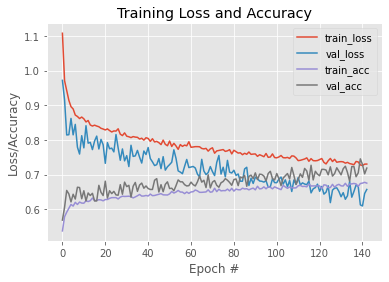

In [ ]:
# FUNCTION TO PLOT THE TRAINING HISTORY

def plot_training_history(H):
  plt.style.use("ggplot")
  plt.figure()

  X = np.arange(0, len(H.epoch))
  plt.plot(X, H.history["loss"], label="train_loss")
  plt.plot(X, H.history["val_loss"], label="val_loss")
  plt.plot(X, H.history["accuracy"], label="train_acc")
  plt.plot(X, H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

plot_training_history(H)


In [26]:

# delete model
del model


-------------

## Preprocess Data, Load model and Make predictions

In [19]:
# LOAD TEST DATA

with open(TEST_DATA_DIR+'Xids_Claims_test.npy', 'rb') as f:
    Xids_Claims_test = np.load(f)
with open(TEST_DATA_DIR+'Xmask_Claims_test.npy', 'rb') as f:
    Xmask_Claims_test = np.load(f)
with open(TEST_DATA_DIR+'Xids_Mtext_test.npy', 'rb') as f:
    Xids_Mtext_test = np.load(f)
with open(TEST_DATA_DIR+'Xmask_Mtext_test.npy', 'rb') as f:
    Xmask_Mtext_test = np.load(f)
with open(TEST_DATA_DIR+'labels_test.npy', 'rb') as f:
    labels_test = np.load(f)
    

In [20]:
Xids_Claims_test

array([[  101.,   107.,  1109., ...,     0.,     0.,     0.],
       [  101.,  8451.,  7085., ...,     0.,     0.,     0.],
       [  101.,   156., 26166., ...,     0.,     0.,     0.],
       ...,
       [  101.,  5893.,  2585., ...,     0.,     0.,     0.],
       [  101.,   789.,  1284., ...,     0.,     0.,     0.],
       [  101.,  1130.,  5842., ...,     0.,     0.,     0.]])

In [21]:
# CONVERT DATA TO TENSORFLOW DATASET

dataset_test = tf.data.Dataset.from_tensor_slices((Xids_Claims_test, Xmask_Claims_test, 
                                                  Xids_Mtext_test, Xmask_Mtext_test, labels_test))
for i in dataset_test.take(1): print(i)


(<tf.Tensor: shape=(45,), dtype=float64, numpy=
array([  101.,   107.,  1109.,  1948.,  1103.,  6652.,  2974.,  1261.,
        1121.,  1121.,  2880.,  6670.,  1229., 20001.,  6652.,  1108.,
        4848.,  1104.,  1352.,   107.,   107.,  1110.,  3817.,  5696.,
         119.,   795.,  1109.,  5317.,  1867.,  1128.,  1169.,   787.,
         189.,  1321.,  1142.,  4333.,   119.,   107.,   102.,     0.,
           0.,     0.,     0.,     0.,     0.])>, <tf.Tensor: shape=(45,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(270,), dtype=float64, numpy=
array([  101.,  1252.,  1103.,  9794.,  1107.,  1142.,  1692.,  1127.,
       11725.,  1121.,  2880.,  6670.,  1115.,  1355.,  1106.,  1103.,
        6652.,  2974.,  1133.,   107.,   107.,  1122.,  2144.,   787.,
         189.,  1474.,  1625.,  116

In [22]:

# map the test data into a dic, and for evaluation put the test labels outside of the dic in the tuple

def map_func(input_ids_claims, masks_claims,input_ids_mtext, masks_mtext, labels):
  return {'input_ids_claims': input_ids_claims, 'attention_mask_claims': masks_claims, 
          'input_ids_mtext': input_ids_mtext, 'attention_mask_mtext': masks_mtext}

def map_func_eval(input_ids_claims, masks_claims,input_ids_mtext, masks_mtext, labels):
  return {'input_ids_claims': input_ids_claims, 'attention_mask_claims': masks_claims, 
          'input_ids_mtext': input_ids_mtext, 'attention_mask_mtext': masks_mtext}, labels

dataset_test_eval = dataset_test.map(map_func_eval)
dataset_test = dataset_test.map(map_func)

for i in dataset_test.take(1): print(i)


{'input_ids_claims': <tf.Tensor: shape=(45,), dtype=float64, numpy=
array([  101.,   107.,  1109.,  1948.,  1103.,  6652.,  2974.,  1261.,
        1121.,  1121.,  2880.,  6670.,  1229., 20001.,  6652.,  1108.,
        4848.,  1104.,  1352.,   107.,   107.,  1110.,  3817.,  5696.,
         119.,   795.,  1109.,  5317.,  1867.,  1128.,  1169.,   787.,
         189.,  1321.,  1142.,  4333.,   119.,   107.,   102.,     0.,
           0.,     0.,     0.,     0.,     0.])>, 'attention_mask_claims': <tf.Tensor: shape=(45,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>, 'input_ids_mtext': <tf.Tensor: shape=(270,), dtype=float64, numpy=
array([  101.,  1252.,  1103.,  9794.,  1107.,  1142.,  1692.,  1127.,
       11725.,  1121.,  2880.,  6670.,  1115.,  1355.,  1106.,  1103.,
        6652.,  2974.,  1133.,   107.,   1

In [23]:
# CREATE 32 BATCHES OF EACH DATASET OBJECTS

batch_size=32
dataset_test = dataset_test.batch(batch_size)
dataset_test_eval = dataset_test_eval.batch(batch_size)


In [31]:
# LOAD MODEL AND WEIGHTS

CLAIM_SEQ_LEN = 45
M_TEXT_SEQ_LEN = 270

model = create_combined_model(CLAIM_SEQ_LEN, M_TEXT_SEQ_LEN)
model.load_weights(CHECKPOINT_PATH)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids_claims (InputLayer)   [(None, 45)]         0                                            
__________________________________________________________________________________________________
attention_mask_claims (InputLay [(None, 45)]         0                                            
__________________________________________________________________________________________________
input_ids_mtext (InputLayer)    [(None, 270)]        0                                            
__________________________________________________________________________________________________
attention_mask_mtext (InputLaye [(None, 270)]        0                                            
____________________________________________________________________________________________

In [35]:
# # EVALUATE MODEL

l_names=["FALSE","MIXTURE","TRUE","UNPROVED"]

print("[INFO]: Evaluating the model...")

# model prediction
labels_pred = model.predict(dataset_test)
y_te, y_pred = labels_test.argmax(axis=1), labels_pred.argmax(axis=1)

# get the classification report
c_report = classification_report(y_te, y_pred, 
                                 target_names=l_names)

c_report_dic = classification_report(y_te, y_pred, 
                                     target_names=l_names, output_dict=True)

print("[INFO]: Done!")


[INFO]: Evaluating the model...
[INFO]: Done!


### Show results

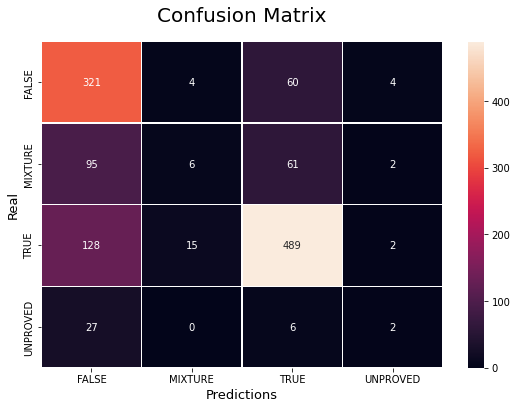

In [26]:
# PLOT CONFUSION MATRIX

# calculate the conf. matrix
cm = confusion_matrix(y_te, y_pred)


# plot the conf. matrix
plt.figure(figsize = (9,6))
ax = plt.axes()

sns.heatmap(cm, ax=ax, annot=True, xticklabels=l_names, 
            yticklabels=l_names, linewidths=.5, fmt='d')

ax.set_title('Confusion Matrix', size=20, pad=20)
ax.set_ylabel('Real', size=13)
ax.set_xlabel('Predictions', size=13)

plt.show()


In [27]:

print(c_report)


              precision    recall  f1-score   support

       FALSE       0.56      0.83      0.67       389
     MIXTURE       0.24      0.04      0.06       164
        TRUE       0.79      0.77      0.78       634
    UNPROVED       0.20      0.06      0.09        35

    accuracy                           0.67      1222
   macro avg       0.45      0.42      0.40      1222
weighted avg       0.63      0.67      0.63      1222



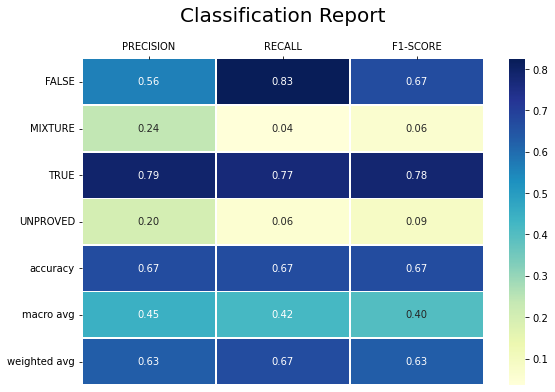

In [28]:
# PLOT HEATMAP OF THE CLASSIFICATION REPORT

plt.figure(figsize = (9,6))
ax = plt.axes()

report = pd.DataFrame(c_report_dic).iloc[:-1, :].T
report.rename(columns={"precision":"PRECISION", "recall":"RECALL", 
                       "f1-score":"F1-SCORE"}, inplace=True)

sns.heatmap(report, ax=ax, annot=True, linewidths=.5, cmap='YlGnBu', fmt='.2f')

ax.set_title('Classification Report', size=20, pad=20)
ax.xaxis.set_ticks_position('top')
plt.show()
